##### Copyright 2019 The TensorFlow Hub Authors.
Licensed under the Apache License, Version 2.0 (the "License");

Created by @[Adrish Dey](https://github.com/captain-pool) for [Google Summer of Code](https://summerofcode.withgoogle.com/) 2019

In [ ]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Image Super Resolution using ESRGAN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/image_enhancing"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/image_enhancing.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/captain-pool/esrgan-tf2/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

This colab demonstrates use of TensorFlow Hub Module for Enhanced Super Resolution Generative Adversarial Network (*by Xintao Wang et.al.*) [[Paper](https://arxiv.org/pdf/1809.00219.pdf)] [[Code](https://github.com/captain-pool/GSOC/)]

for image enhancing. *(Preferrably bicubically downsampled images).*

Model trained on DIV2K Dataset (on bicubically downsampled images) on image patches of size 128 x 128.

The code has been edited for bulk image processing for Capstone Study by Hyun Woo Lim [[email](hwl278@edu)]

Original Code accessible [[here](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/image_enhancing.ipynb#scrollTo=ZX-deZlhqaYz)]

**Preparing Environment**

In [ ]:
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [ ]:
!wget "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" -O original.png

--2023-12-13 19:59:41--  https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png
Resolving user-images.githubusercontent.com (user-images.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to user-images.githubusercontent.com (user-images.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34146 (33K) [image/png]
Saving to: ‘original.png’

original.png        100%[===================>]  33.35K  --.-KB/s    in 0.002s  

2023-12-13 19:59:41 (16.3 MB/s) - ‘original.png’ saved [34146/34146]



In [ ]:
# Declaring Constants
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

**Defining Helper Functions**

In [ ]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)

def save_image(image, filename, dst):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save(os.path.join(dst,filename))
  print(f"Saved %s.jpg at {dst}" % filename)

In [ ]:
%matplotlib inline
def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

### Uploading images files for bulk generation

In [ ]:
import os
from google.colab import files
import shutil

upload_folder = 'upload'
result_folder = 'results'

if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)
os.mkdir(upload_folder)
os.mkdir(result_folder)

# upload images
uploaded = files.upload()
for filename in uploaded.keys():
  dst_path = os.path.join(upload_folder, filename)
  print(f'move {filename} to {dst_path}')
  shutil.move(filename, dst_path)

Saving 809a8eafc9ad1239673db883fcb2be.jpeg to 809a8eafc9ad1239673db883fcb2be.jpeg
Saving 18d7dd09d1801e5b89517f4f271c64.jpeg to 18d7dd09d1801e5b89517f4f271c64.jpeg
Saving 0a8c8eb6240b5dee76e39c6be41902.jpeg to 0a8c8eb6240b5dee76e39c6be41902.jpeg
Saving 115e8885890dc7d3c0d52e77741886.jpeg to 115e8885890dc7d3c0d52e77741886.jpeg
Saving 8d06a6811b9ce1f53e271621fd0a0b.jpeg to 8d06a6811b9ce1f53e271621fd0a0b.jpeg
Saving 1f4d1f6babc922acc25d10b570c199.jpeg to 1f4d1f6babc922acc25d10b570c199.jpeg
Saving 3c68880e666c18bc4fe3c62f3459dc.jpeg to 3c68880e666c18bc4fe3c62f3459dc.jpeg
Saving 407ff29e4a8e32430a03e9dc6f193b.jpeg to 407ff29e4a8e32430a03e9dc6f193b.jpeg
Saving 75beaf6c749a25bd74bc3ab8088dc2.jpeg to 75beaf6c749a25bd74bc3ab8088dc2.jpeg
Saving 29edf12495da9563dcec6775e18f9f.jpeg to 29edf12495da9563dcec6775e18f9f.jpeg
Saving 3b69169daff7b8485197ba637a7db4.jpeg to 3b69169daff7b8485197ba637a7db4.jpeg
Saving 3adf8105b269c0fcf7663d6e674b6b.jpeg to 3adf8105b269c0fcf7663d6e674b6b.jpeg
Saving 85c0bb3cc

### Loading ESRGAN Model

In [ ]:
model = hub.load(SAVED_MODEL_PATH)

### Inference for uploaded images -> Save in Result

ESRGANed 809a8eafc9ad1239673db883fcb2be.jpeg in results
Saved 809a8eafc9ad1239673db883fcb2be.jpeg.jpg at results
ESRGANed 18d7dd09d1801e5b89517f4f271c64.jpeg in results
Saved 18d7dd09d1801e5b89517f4f271c64.jpeg.jpg at results
ESRGANed 0a8c8eb6240b5dee76e39c6be41902.jpeg in results
Saved 0a8c8eb6240b5dee76e39c6be41902.jpeg.jpg at results
ESRGANed 115e8885890dc7d3c0d52e77741886.jpeg in results
Saved 115e8885890dc7d3c0d52e77741886.jpeg.jpg at results
ESRGANed 8d06a6811b9ce1f53e271621fd0a0b.jpeg in results
Saved 8d06a6811b9ce1f53e271621fd0a0b.jpeg.jpg at results
ESRGANed 1f4d1f6babc922acc25d10b570c199.jpeg in results
Saved 1f4d1f6babc922acc25d10b570c199.jpeg.jpg at results
ESRGANed 3c68880e666c18bc4fe3c62f3459dc.jpeg in results
Saved 3c68880e666c18bc4fe3c62f3459dc.jpeg.jpg at results
ESRGANed 407ff29e4a8e32430a03e9dc6f193b.jpeg in results
Saved 407ff29e4a8e32430a03e9dc6f193b.jpeg.jpg at results
ESRGANed 75beaf6c749a25bd74bc3ab8088dc2.jpeg in results
Saved 75beaf6c749a25bd74bc3ab8088dc2.jpe

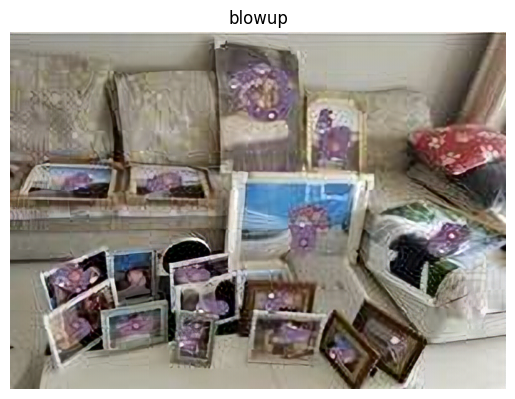

In [ ]:
failed = []

for filename in uploaded.keys():
  try:
    image = preprocess_image(os.path.join(upload_folder, filename))
    start = time.time()
    esrgan = model(image)
    esrgan = tf.squeeze(esrgan)
    print("Time Taken: %f" % (time.time() - start))

    # plot_image(tf.squeeze(image), title = "Original")
    # plot_image(esrgan, title = "blowup")

    save_image(esrgan, filename, result_folder)
    print(f'ESRGANed {filename} in {result_folder}')
  except:
    print(f"Failed processing {filename}")
    failed.append(filename)

if failed:
  print("Failed item list: ")
  for item in failed:
    print(item)


### Download ESRGAN images

In [ ]:
# Download the results
zip_filename = 'ESRGAN_result.zip'
if os.path.exists(zip_filename):
  os.remove(zip_filename)
os.system(f"zip -r -j {zip_filename} results/*")
files.download(zip_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>